In [1]:
import pip

while True:
    
    try:
        #import your modules here. !
        import numpy as np
        import os
        from glob import glob
        import torch
        from PIL import Image
        from medmnist import PneumoniaMNIST
        import matplotlib.pyplot as plt
        import torch.nn.functional as F
        from sklearn.metrics import roc_curve, auc
        import SimpleITK as sitk
        from IPython.display import display, clear_output
        break

    except ImportError as err_mdl:
        
        print((err_mdl.name))
        pip.main(['install', err_mdl.name])

    
!git clone https://github.com/clarastegehuis/machine_learning_medical_data_workshop/

# De wiskunde achter AI - *Toepassing: medische data*
Neurale netwerken kunnen worden gebruikt om automatisch beelden te interpreteren. Computers zijn zelfs beter in sommige beeldanalyse taken dan mensen, omdat mensen een korte concentratieboog hebben. 
In deze workshop krijg je een inkijkje in hoe een computer beelden kan interpreteren. We gaan aan de slag met een (openbare) medische dataset en ons eigen netwerk trainen wat onderscheid kan maken tussen plaatjes van zieke en gezonde longen.

**Voor je begint met de code runnen**

Klik op ' Runtime'  bovenaan de pagine, en op ' runtime options'. Selecteer daar een vakje waar ' GPU'  bij staat.

**Hoe gebruik je dit bestand?**

Dit bestand is een *jupyter notebook*, dat bestaat uit tekstcellen (zoals deze) en codecellen (zoals die hierboven). Code cellen kun je runnen met <kbd>shift</kbd> + <kbd>enter</kbd>. Voordat je verder gaat, is het belangrijk om de cel hierboven te runnen, zodat de computer alle nodige functies kan importeren.
In sommige gevallen moet je zelf een stukje code schrijven. Geen paniek, er lopen hier genoeg mensen rond om je een handje te helpen.


### Digitale beelden
Een computer ziet een beeld als een grote matrix met getallen, elk element in de matrix (beter bekend als *pixel*) bevat de lokale beeldintensiteit. In het geval van een kleurenbeeld zijn het drie matrices over elkaar, die respectievelijk het rode, blauwe en groene kanaal voorstellen. In het geval van een zwart-wit beeld is het digitale beeld een enkele matrix met intensiteiten.

Hieronder laden we eerst een beeld uit de zogenaamde Ribs dataset, die röntgenfoto's van ribbenkasten bevat.

In [2]:
#definieer twee functies die je later kan gebruiken om de images te openen en te visualiseren
def open_img(path):
    if path.endswith('.png'):
        return np.array(Image.open(path).convert('L'))
    elif path.endswith('.mhd'):
        return sitk.GetArrayFromImage(sitk.ReadImage(path))[32,:,:] # return 1 slice of the image

def visualize(img, clim=[-300,450]):
    plt.imshow(img, cmap='gray', clim=clim)
    plt.axis('off')
    plt.show()

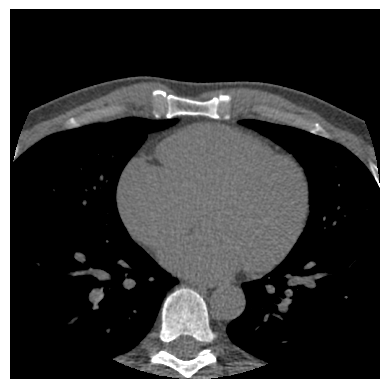

In [3]:
# inladen van beeld van de ribbenkast
# definieer pad naar beeld
# img_path = 'data/ribs/VinDr_RibCXR_train_000.png'
img_path = '/content/machine_learning_medical_data_workshop/TEV1P1CTI.mhd'
img = open_img(img_path)
# visualiseer beeld
visualize(img)

Uit hoeveel pixels bestaat dit beeld?

In [4]:
# type/programmeer je antwoord hier
print(np.shape(img))

(512, 512)


### Convoluties
Een computer kan een beeld begrijpen door middel van zogenaamde convoluties. Een convolutie bestaat altijd uit een *kernel*, een kleine matrix met daarin een kenmerkend patroon, die lokaal wordt vermenigvuldigd met de beeldintensiteiten. In de onderstaande animatie is het bovenste groene vlak de kernel, en het blauwe vlak het te interpreteren beeld, het schuiven van de kernel noemen we de convolutie. Het resultaat van een convolutie is nog steeds een *matrix*, die vergelijkbare afmetingen heeft als het originele beeld.

![](https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif?20190413174630)

 Met een convolutie wordt in feite de intensiteit van iedere pixel vergeleken met die van zijn buren, afhankelijk van het patroon in de kernel. Door het patroon in de kernel slim te kiezen, kunnen bepaalde features in het beeld worden opgepikt, bijvoorbeeld verticale randen. Effectief wordt er per pixel gekeken hoe zijn omgeving matcht met het patroon in de kernel. Daarnaast kan een convolutie gebruikt worden om ruis in een beeld te verminderen, dit noemen we *smoothing*.
 
 Hieronder laten we een paar voorbeelden van convolutiekernels zien, aan jullie om te beschrijven wat voor effect ze hebben op het beeld.

In [5]:
# dit is een functie die een convolution toepast op een beeld
def apply_conv(image, kernel, iter=1):
    image, kernel = torch.from_numpy(image).float(), torch.from_numpy(kernel).float()
    img_shape, kernel_shape = image.shape, kernel.shape
    fig, ax = plt.subplots(1,1)
    for level in range(iter):
        image = F.conv2d(image.reshape(1,1, img_shape[0], img_shape[1]),
                         kernel.reshape(1,1, kernel_shape[0], kernel_shape[1]),
                         padding='same').squeeze()
        ax.imshow(image.numpy(), cmap='gray', clim=[-300,450])
        ax.set_title(f'Applied convolution {level} times')
        display(fig)
        clear_output(wait=True)
        plt.pause(0.1)

Nu kun je zelf een kernel loslaten op het beeld van de ribbeln. Wat gebeurt er met het beeld door de convolutie? En wat gebeurt er als je meerdere convoluties achter elkaar toepast?

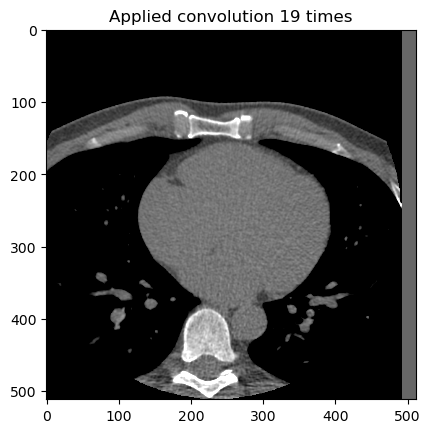

In [6]:
# convolutie 1: detecteren verschuiven naar links
# eerst kernel definieren:
kernel = np.array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 0, 0]])
# hoe vaak willen we de convolutie toepassen?
n_iters = 20

apply_conv(img, kernel, n_iters)

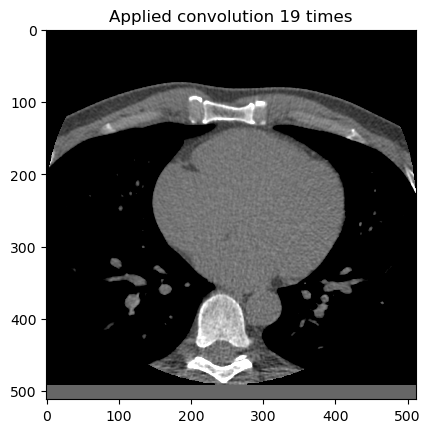

In [7]:
# convolutie 2: verschuiven naar boven
# eerst kernel definieren:
kernel = np.array([[0, 0, 0],
                   [0, 0, 0],
                   [0, 1, 0]])
# hoe vaak willen we de convolutie toepassen?
n_iters = 20

apply_conv(img, kernel, n_iters)

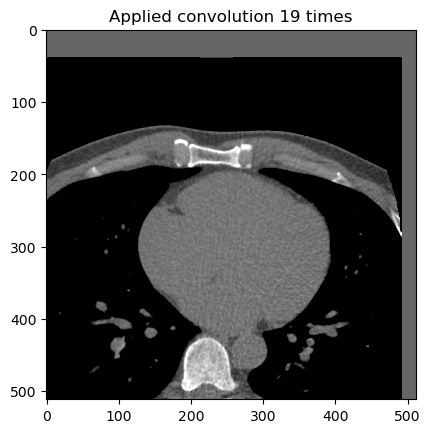

In [8]:
# Opdracht: maak een convolutie die het beeld een paardensprong laat maken
# ANTWOORD:
kernel = np.array([[0, 0, 0, 1, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0]])

n_iters = 20

apply_conv(img, kernel, n_iters)

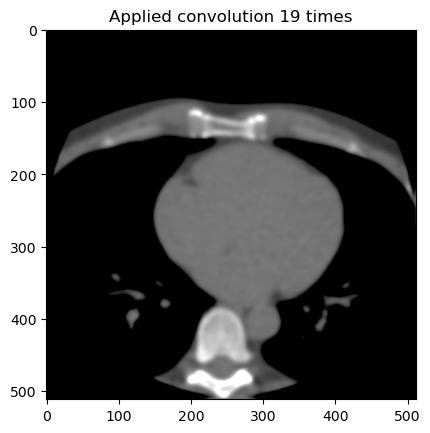

In [9]:
# convolutie 3: Een convolutie die 'smoothing' toepast: Voor iedere pixel neemt de convolution het gewogen gemiddelde van de pixelwaarde en de pixelwaarden van de 8 omliggende pixels. Wat gebeurt er als je de gewichten van de kernel aanpast?
kernel = np.array([[1, 2, 1],
                   [2, 4, 2],
                   [1, 2, 1]]) * 1/16

n_iters = 20

apply_conv(img, kernel, n_iters)

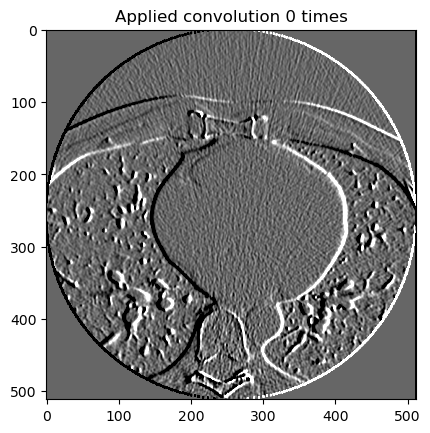

In [10]:
# convolutie 3: detecteren van verticale lijnen
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

n_iters = 1

apply_conv(img, kernel, n_iters)


# opdracht:kun je ook een kernel maken die horizontale randen vindt?

Deze convolutieoperaties vormen de basis van een zogenaamd *convolutional neural network*. In principe is dit een neuraal netwerk dat kan worden ingezet voor allerlei computer vision taken, zoals het classificeren van beelden, objecten detecteren of zelfs de precieze grenzen van een object vinden in een beeld. Convolutional neural networks bestaan uit een stapeling van convoluties. Door convoluties vaker toe te passen in een 'stapel', kan de computer een groeiende lokale regio rondom elke pixel kan bekijken (perceptive field).
De kernels in al deze convoluties worden niet door mensen bepaald, maar worden bepaald tijdens het *trainen* van dit netwerk. In de rest van dit notebook laten we een klein voorbeeld zien van hoe dit werkt en hoe we kunnen bepalen hoe goed dit netwerk is in zijn taak.

**De taak:**

We maken gebruik van de zogenaamde pneumonia dataset. Deze bevat gedownsamplede röntgenfoto's van de borstkas, van zowel gezonde patienten als van patienten met een longontsteking. We gaan een neuraal netwerk trainen die automatisch voor een dergelijk beeld kan bepalen of er sprake is van longontsteking of niet.

In [11]:
# downoald de dataset met foto's van de longen
import medmnist
%pip install monai

dataset = medmnist.PneumoniaMNIST(split="train", download=True)

In [12]:
import monai
# maak een custom dataset class die de data in de juiste vorm geeft

class MedMNISTData(monai.data.Dataset):
    
    def __init__(self, datafile, transform=None):
        self.data = datafile
        self.transform = transform
        
        
    def __getitem__(self, index):
        # Make getitem return a dictionary with keys ['img', 'label'] for the image and label respectively
        image = torch.from_numpy(np.array(self.data[index][0])).float()
        if self.transform:
            image = self.transform(image)
        return {'img': image, 'label': self.data[index][1]}
    
    def __len__(self):
        return len(self.data)

In [13]:
# Een functie die de foto's uit de dataset visualiseert
def visualize_sample(sample):
    plt.imshow(sample['img'], 'gray')
    if sample['label'] == 1:
        plt.title('Patient with pneumonia')
    else:
        plt.title('Healthy patient')
    plt.show()

In [14]:
# Intensiteiten normaliseren voor het netwerk straks
from monai.transforms import NormalizeIntensity

data_transform = NormalizeIntensity(subtrahend=.5, divisor=.5)

Hieronder kun je een foto de longen van een willekeurige patient laten zien. Om de voorspellingen van het algoritme later beter te kunnen interpreteren, is het belangrijk om te weten hoe veel foto's er in de data zitten van gezonde longen, en hoe veel er van ongezonde longen inzitten.

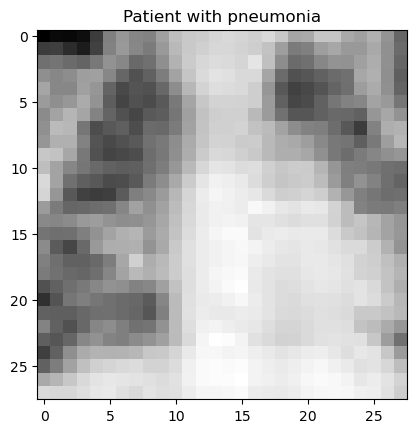

{0: 1214, 1: 3494}


In [23]:
train_dataset = MedMNISTData(dataset, transform=data_transform)

# visualiseer een random sample
index = np.random.choice(np.arange(len(train_dataset)))
visualize_sample(train_dataset[index])

#Vraag: is deze dataset imbalanced? 
counts = {0: 0, 1:0}
for sample in train_dataset:
    counts[sample['label'][0]] += 1
print(counts)

Nu gaan we het echte netwerk aanmaken. We splitsen de data in een testset en een validatieset om later te kunnen kijken of het model niet overfit. We maken een model met twee lagen van convoluties van 3x3 kernels.

In [24]:
# validatiedataset aanmaken, om te kijken hoe het model generaliseert tijdens het trainen. De validatieset wordt niet gebruikt om de gewichten van het model op te fitten.
val_dataset = MedMNISTData(medmnist.PneumoniaMNIST(split='val', download=False))

In [25]:
# dataloader die de data inlaadt voor het trainen
train_dataloader = monai.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = monai.data.DataLoader(val_dataset, batch_size = 32, shuffle=False)

In [26]:
# Hier wordt het echte model gedefinieerd. Dit model is een convolutioneel neuraal netwerk (CNN) dat bestaat uit 2 convolutionele lagen en 2 fully connected lagen.
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)             # Een convolutie met 1 input channel (de afbeelding), 32 output channels (32 verschillende kernels), 3x3 pixel kernel
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)            # Een tweede convolutie met 32 input channels (de 32 output channels van de vorige laag), 64 output channels (verschillende kernels), 3x3 pixel kernel
        self.fc1 = nn.Linear(in_features=9216, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=1)                                       # De output laag met 1 output neuron (de voorspelling, tussen 0 (geen longontsteking) en 1( longontsteking) )

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        output = self.fc2(x)
        return output
    
net = Net()

# Vraag: wat is de receptive field van dit netwerk?


# Vraag: hoeveel weights heeft dit netwerk?

In [27]:
model = Net()
model.cuda() # op de GPU zetten, zodat het trainen sneller gaat


optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# loss functie: Binary cross entropy (want classificatie). Logits is alleen zodat je de sigmoid en bce in 1 functie hebt.
loss_function = torch.nn.BCEWithLogitsLoss()

In [28]:
from tqdm import tqdm
# functie om het model te trainen

def train_medmnist(model, train_dataloader, val_dataloader, optimizer, epochs, device='cuda', val_freq=1):
    train_loss = []
    val_loss = []

    for epoch in tqdm(range(epochs)):
        # model in train modus
        model.train()
        steps = 0
        epoch_loss = 0
        # loop over de batches in training data
        for batch in train_dataloader:
            optimizer.zero_grad()
            images = batch['img'].float().to(device)
            labels = batch['label'].float().to(device)
            # haal plaatjes door het model
            output = model(images.unsqueeze(1)) 
            # bereken de loss tussen de targets en de outputs van het model
            loss = loss_function(output, labels)
            epoch_loss += loss.item()
            # back propagation, update de weights in het netwerk
            loss.backward()
            optimizer.step()
            steps += 1
           
        train_loss.append(epoch_loss/steps)

        # validation loop
        if epoch % val_freq == 0:
            steps = 0
            val_epoch_loss = 0
            model.eval()
            for batch in val_dataloader:
                images = batch['img'].float().to(device)
                labels = batch['label'].float().to(device)
                output = model(images.unsqueeze(1)) 
                loss = loss_function(output, labels)
                val_epoch_loss += loss.item()
                steps += 1
            val_loss.append(val_epoch_loss/steps)

    # plot the losses together
    plt.plot(train_loss, label='train loss')
    plt.plot(np.arange(0, epochs, val_freq), val_loss, label='val loss')
    plt.legend()
    plt.show()

    return model, train_loss, val_loss

In [41]:
val_freq = 10

# 100 iteraties trainen
n_epochs = 100
model, train_loss, val_loss = train_medmnist(model, train_dataloader, val_dataloader, optimizer, epochs=n_epochs, val_freq=val_freq)

# Vraag: is dit model overfitted?

  0%|          | 0/100 [00:00<?, ?it/s]


AssertionError: Torch not compiled with CUDA enabled

We hebben hierboven gezien wat specifieke kernels kunnen herkennen in een beeld. Maar wat heeft ons algoritme voor kernels gevonden om te classificeren tussen gezonde en zieke longen? Hieronder zien we de kernels van de tweede laag van convoluties.

/tmp/ipykernel_1889434/2025591104.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


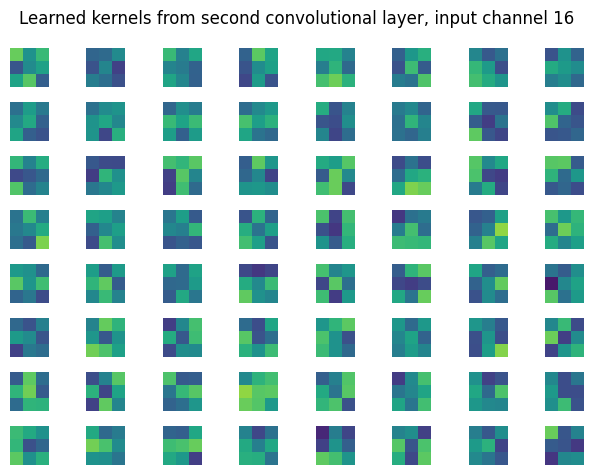

In [149]:
input_index = 16
fig, axs = plt.subplots(8,8, layout='constrained')
for i in range(64):
    kernel = model.conv2.weight[i,input_index,:,:].detach().cpu().numpy()
    cur_ax = np.unravel_index(i, [8,8])
    s = axs[cur_ax].imshow(kernel, clim=[-0.1,0.1],cmap = ' Greys')
    axs[cur_ax].axis('off')
plt.suptitle(f'Geleerde kernels uit de tweede convolutional laag, input channel {input_index}')
plt.tight_layout()
plt.show()


## Performance assessment

Nu we het model getraind hebben, gaan we kijken in hoeverre dit model goede voorspellingen kan doen. Eerst bepalen we de recall en precision van het model. De recall vertelt ons hoeveel van de positieven er gemist worden door het model (vals negatieven). De precisie meet hoeveel van de positief geclassificeerde samples daadwerkelijk positieve samples zijn (vals positieven). Welke maat belangrijker is, is afhankelijk van het probleem. Bij het detecteren van een extreem zeldzame vorm van kanker heb je bijvoorbeeld het liefst een hoge recall en accepteer je daarmee een lagere precisie. Het is beter om de daadwerkelijke positieven wél te detecteren en daarmee in een vervolgonderzoek de vals positieven eruit te filteren, dan de positieven compleet te missen.
We gebruiken de test dataset (dus niet de validatiedataset) om deze metrics te bepalen.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)

Voordat we deze metrics gaan bepalen, bekijken we eerst een paar outputs van het model.


In [114]:
def validation_results_visualize(model, dataset):
    index = np.random.randint(0, len(dataset))
    image = dataset[index]['img']
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    image = image.float().to('cuda')
    label = dataset[index]['label'].item()
    with torch.no_grad():
        output = F.sigmoid(model(image.view(1,1,28,28))).squeeze()
    plt.title(f'Ground truth: {label}, prediction: {int(output)}')
    plt.show()

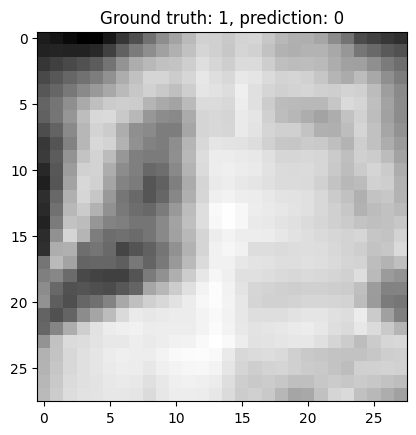

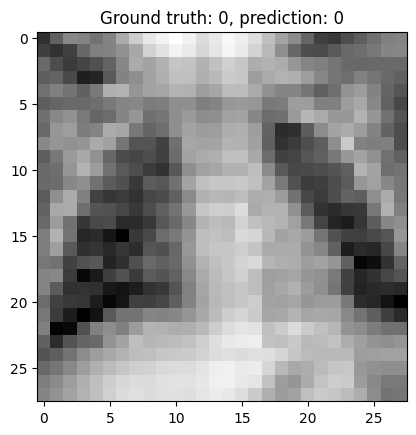

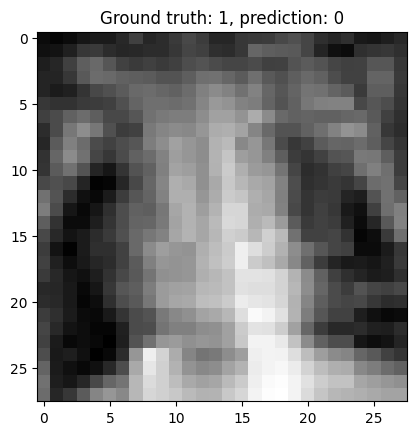

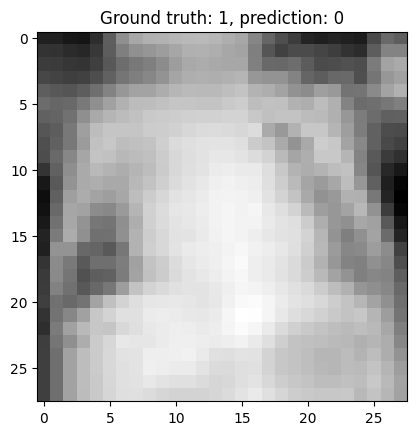

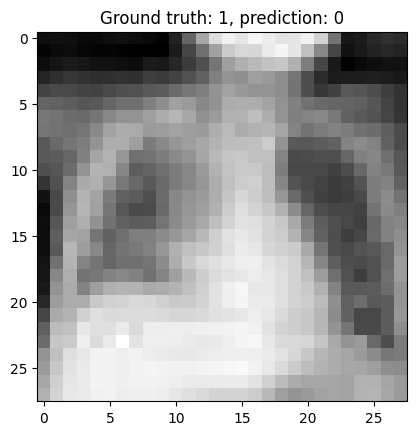

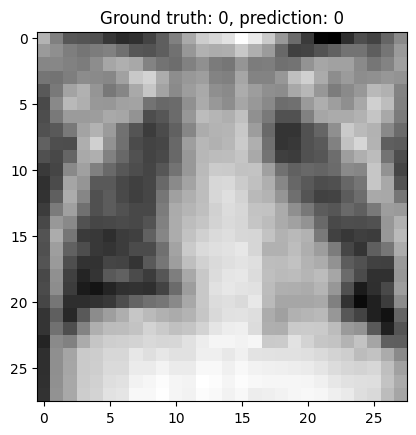

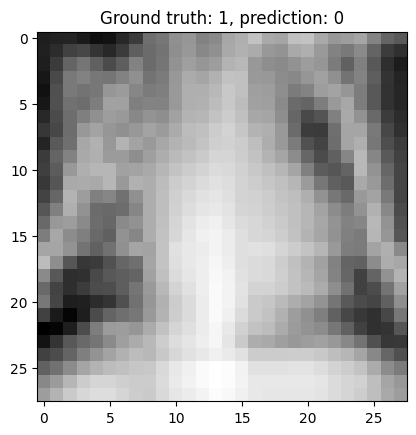

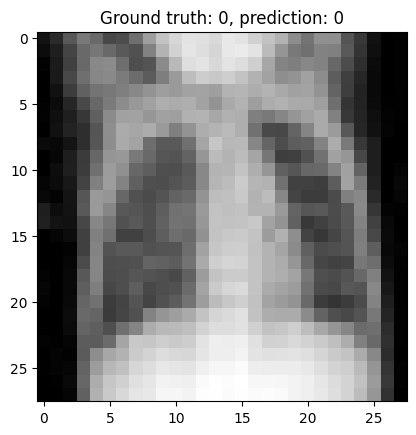

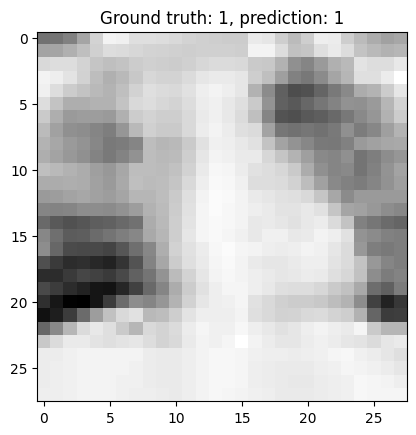

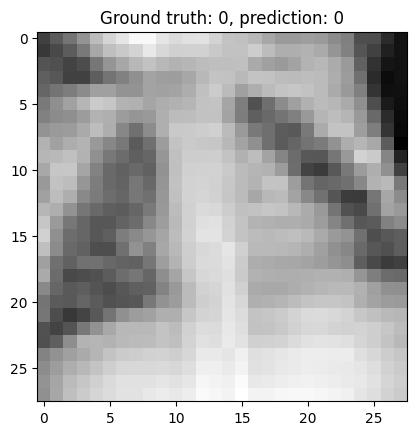

In [115]:
for i in range(10):
    validation_results_visualize(model, val_dataset)

In [104]:
# deze functien berekent de precision en recall van het model
def get_precision_recall(model, dataloader):
    model.eval()
    TP, TN, FP, FN = 0, 0, 0, 0
    total = 0
    for data in dataloader:
        images = data['img'].float().to('cuda')
        labels = data['label'].squeeze()
        total += len(labels)
        with torch.no_grad():
            output = F.sigmoid(model(images.unsqueeze(1))).squeeze().cpu()
        pred_classes = (output >= 0.5).to(torch.int8)
        TP += (pred_classes * labels).sum()
        TN += ((1 - pred_classes) * (1 - labels)).sum()
        FP += (pred_classes * (1 - labels)).sum()
        FN += ((1 - pred_classes) * labels).sum()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return precision, recall   

In [ ]:
test_dataset = MedMNISTData(medmnist.PneumoniaMNIST(split='test', download=False))
test_loader = monai.data.DataLoader(test_dataset, batch_size = 32, shuffle=False)

precision, recall = get_precision_recall(model, test_loader)
print(f'De precision van het getrainde model is {precision:.2f}, de recall van het getrainde model is {recall:.2f}.')

De precision van het getrainde model is 0.81, de recall van het getrainde model is 0.99


Eventueel nog een auc curve bepalen van het model:

In [124]:
# Performance evaluation
def validation_results_ROC(model, dataloader):
    GT_labels, pred_labels = [], []
    for data in dataloader:
        images = data['img'].float().to('cuda')
        GT_labels.append(data['label'].squeeze().numpy())
        with torch.no_grad():
            output = model(images.unsqueeze(1)).cpu().squeeze()
        pred_labels.append(output.numpy())
    fpr, tpr, _ = roc_curve(np.concatenate(GT_labels), np.concatenate(pred_labels))
    plt.plot(fpr,tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('False negative rate')
    plt.plot([0,1], [0,1], 'r--')
    plt.title(f'AUC: {auc(fpr, tpr):.2f}')

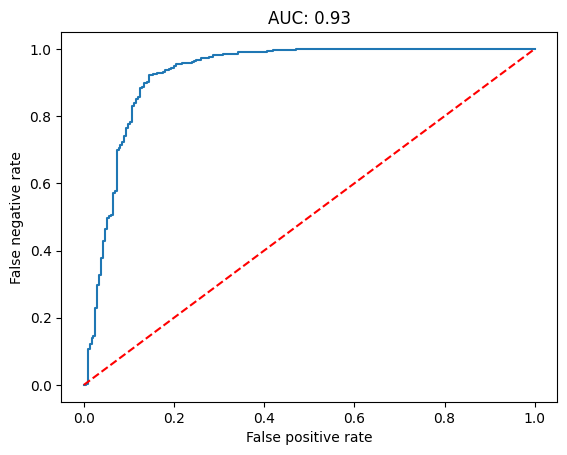

In [125]:
validation_results_ROC(model, test_loader)